In [8]:
# !pip install episcanpy
# !pip install scanpy
# !pip install anndata
# !pip install desc
# !pip install display
# !pip install --pre deepchem --user
# !pip install nfp

# !pip install --force-reinstall numpy==1.19.5
#!conda install -c conda-forge scanpy python-igraph leidenalg

In [7]:
# -------------
# Basic Imports
# -------------
import numpy as np, pandas as pd, gzip, csv, os, matplotlib.pyplot as plt, warnings, requests
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.preprocessing import StandardScaler


%matplotlib inline
warnings.filterwarnings("ignore")

# --------------------------
# Imports for Bioinformatics
# --------------------------
import scanpy as sc

import deepchem as dc
dc.__version__

from rdkit import Chem
from rdkit.Chem import RDKFingerprint

# import desc as desc

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3             
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

#### Creating Circular Fingerprints ( Neural based fingerprint creation - GNN )

In [4]:
train_data_path = "."
main_data = pd.read_csv(train_data_path+'/final_data.csv')
print(main_data.shape)
main_data.head()


(23052, 8)


,Unnamed: 0,drug_a_name,drug_b_name,cell_line,synergy,fold,drug_a_structure,drug_b_structure
0,5-FU_ABT-888_A2058,5-FU,ABT-888,A2058,7.693530,2,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
1,5-FU_ABT-888_A2780,5-FU,ABT-888,A2780,7.778053,2,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
2,5-FU_ABT-888_A375,5-FU,ABT-888,A375,-1.198505,2,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
3,5-FU_ABT-888_A427,5-FU,ABT-888,A427,2.595684,2,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
4,5-FU_ABT-888_CAOV3,5-FU,ABT-888,CAOV3,-5.139971,2,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1


In [5]:
from sklearn.preprocessing import StandardScaler
data_for_gnn = main_data[['drug_a_structure', 'drug_b_structure', 'cell_line', 'synergy']].copy()
data_for_gnn = data_for_gnn.sample(frac=1).reset_index().drop(['index'], 1)

# scaler = StandardScaler().fit(data_for_gnn['synergy'].values.reshape(-1,1))
# scaled_ops = scaler.transform(data_for_gnn['synergy'].values.reshape(-1,1))
# data_for_gnn['synergy'] = scaled_ops
data_for_gnn.head()

,drug_a_structure,drug_b_structure,cell_line,synergy
0,CCC1(O)CC2CN(CCc3c([nH]c4ccccc34)C(C(=O)OC)(c3...,CS(=O)(=O)CCNCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5ccc...,MDAMB436,-15.418132
1,O=P1(N(CCCl)CCCl)NCCCO1,COC1=C2CC(C)CC(OC)C(O)C(C)C=C(C)C(OC(N)=O)C(OC...,UWB1289,-8.103769
2,CN1C(=O)C=CC2(C)C3CCC4(C)C(NC(=O)OCC(F)(F)F)CC...,CC1CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O...,NCIH23,2.450127
3,O=S1(=O)NC2(CN1CC(F)(F)F)C1CCC2Cc2cc(C=CCN3CCC...,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,OV90,-2.899168
4,O=P1(N(CCCl)CCCl)NCCCO1,CS(=O)(=O)CCNCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5ccc...,A375,-10.042138


In [6]:
data_for_gnn.shape

(23052, 4)

In [7]:
## Need to remove all drug smiles with '.' in them - this '.' 
#          creates separate isolated and disconnected graphs and 
#          it gets hard to calculate adjacency matrix and update them

#### updated version:

In [8]:
# train_data_path = "/content/drive/My Drive/Projects and research stuffs/Drug Synergy/Dataset for GNN"
# main_data = pd.read_csv(train_data_path+'/final_data.csv')
# print(main_data.shape)
# main_data.head()


data_for_gnn = main_data[['drug_a_structure', 'drug_b_structure', 'cell_line', 'synergy']].copy()
data_for_gnn = data_for_gnn.sample(frac=1).reset_index().drop(['index'], 1)

# scaler = StandardScaler().fit(data_for_gnn['synergy'].values.reshape(-1,1))
# scaled_ops = scaler.transform(data_for_gnn['synergy'].values.reshape(-1,1))
# data_for_gnn['synergy'] = scaled_ops
data_for_gnn.head()


,drug_a_structure,drug_b_structure,cell_line,synergy
0,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,Cn1c(=O)n(-c2ccc(C(C)(C)C#N)cc2)c2c3cc(-c4cnc5...,ZR751,21.548383
1,CS(=O)(=O)CCNCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5ccc...,COC1CC2CCC(C)C(O)(O2)C(=O)C(=O)N2CCCCC2C(=O)OC...,VCAP,14.617611
2,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)CC(O)(C(=...,NC(=O)c1cccc2cn(-c3ccc(C4CCCNC4)cc3)nc12,PA1,-13.653373
3,COC12C(COC(N)=O)C3=C(C(=O)C(C)=C(N)C3=O)N1CC1NC12,CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc(F)c...,RPMI7951,-5.641747
4,CS(=O)(=O)CCNCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5ccc...,O=C(O)C1(Cc2cccc(Nc3nccs3)n2)CCC(Oc2cccc(Cl)c2...,LOVO,28.431355


In [10]:
# main_data.head()

#### Pre-processing gene expression attribute matrix and edge matrix

In [ ]:
# Read attribute matrix
ccle_attr = pd.read_csv('gene_attribute_matrix.txt.gz', sep='\t')
print(ccle_attr.shape)


cell2ind = pd.DataFrame(columns = ['index','Cell_lines'])
cell2ind['Cell_lines'] = list(ccle_attr.columns[3:])
cell2ind['index'] =  list(cell2ind.index)
print(cell2ind.head())



gene2ind = pd.DataFrame(columns = ['index','Genes', 'Gene_id'])
gene2ind['Genes'] =  list(ccle_attr['#'].values[2:])
gene2ind['index'] =  list(gene2ind.index)
gene2ind['Gene_id'] =  list(ccle_attr['CellLine'].values[2:])
print(gene2ind.head())

cell2exp = pd.DataFrame(columns = ['expression'])
l = []
for cells_ind in range(len(cell2ind['Cell_lines'])):
    l.append(list(ccle_attr[cell2ind['Cell_lines'].iloc[cells_ind]].values[2:]))
    
cell2exp['expression'] = l
print(cell2exp.head())

In [ ]:
print(gene2ind.shape)

In [ ]:
pp_int = pd.read_csv('/content/drive/My Drive/Projects and research stuffs/Drug Synergy/Dataset for GNN/PP-Pathways_ppi.csv.gz', header=None)
pp_int.columns = ['Protein1', 'Protein2']
pp_int.head()

In [ ]:
# This dataset has proper gene-gene interactions
# pp_int[pp_int['Protein1'] == 2200][:2]

In [ ]:
# If any genes are cell line ids, remove them
cell_ids = cell2ind['Cell_lines'].unique()
to_drop = []
for i in range(len(gene2ind)):
  if(gene2ind.iloc[i]['Genes'] in cell_ids):
    to_drop.append(i)

print(len(to_drop))

gene2ind = gene2ind.drop(to_drop, axis = 0)

In [ ]:
gene2ind.shape

In [ ]:
# Check and take only intersection of gene ids

# Create set of all values from both p1 and p2 columns
p1p2 = set()
# for i in range(len(pp_int)):
#   p1p2.add(pp_int['Protein1'].iloc[i])
#   p1p2.add(pp_int['Protein2'].iloc[i])

p1p2 = set(np.concatenate((pp_int['Protein1'].unique(), pp_int['Protein2'].unique())))
print('Total gene ids in pp_int dataset: ', len(p1p2))

#### Check if any gene ids from deepsynergy dataset is missing in this p1p2
common_gene_ids = []
uncommon_gene_ids = []

for i in range(len(gene2ind)):
  if(gene2ind.iloc[i]['Gene_id'] in p1p2):
    common_gene_ids.append(gene2ind.iloc[i]['Gene_id'])
  else:
    uncommon_gene_ids.append(gene2ind.iloc[i]['Gene_id'])

print('Total Common intersecting gene ids:', len(common_gene_ids), ' and Total uncommon non-intersecting gene ids: ', len(uncommon_gene_ids))



In [ ]:
# Take only 5k genes (avoid computational problems )
# final_gene_ids = common_gene_ids[:10000]



In [ ]:
ccle_attr.head()

,#,#.1,CellLine,CHL1,HMCB,HS852T,HS695T,A101D,HS294T,SNU466,...,HEL9217,HEL,UT7,SET2,MOLM16,KU812,TF1,MEG01,KYO1,K562
0,#,#,Tissue,skin,skin,skin,skin,skin,skin,central nervous system,...,haematopoietic and lymphoid tissue,haematopoietic and lymphoid tissue,haematopoietic and lymphoid tissue,haematopoietic and lymphoid tissue,haematopoietic and lymphoid tissue,haematopoietic and lymphoid tissue,haematopoietic and lymphoid tissue,haematopoietic and lymphoid tissue,haematopoietic and lymphoid tissue,haematopoietic and lymphoid tissue
1,GeneSym,NaN,GeneID/NA,na,na,na,na,na,na,na,...,na,na,na,na,na,na,na,na,na,na
2,FBN1,na,2200,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,...,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000
3,ITGBL1,na,9358,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
4,LRP1,na,4035,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000


#### Re-read cell_attr, this time ignore uncommon gene ids

In [ ]:
# Remove rows where id not present in common gene ids
to_drop = []
for i in range(2, len(ccle_attr)):
  if(ccle_attr.iloc[i]['CellLine'] not in common_gene_ids):
    to_drop.append(i)

print('dropping ', len(to_drop), ' genes')
ccle_attr = ccle_attr.drop(to_drop, axis = 0)
print(ccle_attr.shape)


dropping  3031  genes
(14996, 1040)


In [ ]:
# Drop from pp_int dataset
to_drop = set()
for i in range(len(pp_int)):
  if(pp_int.iloc[i]['Protein1'] not in common_gene_ids):
    to_drop.add(i)
  if(pp_int.iloc[i]['Protein2'] not in common_gene_ids):
    to_drop.add(i)

to_drop = list(to_drop)
print(pp_int.shape)
pp_int = pp_int.drop(to_drop, axis = 0)
print(pp_int.shape)



(342353, 2)
(261342, 2)


In [ ]:
ccle_attr = ccle_attr.reset_index().drop(['index'], axis = 1)
pp_int = pp_int.reset_index().drop(['index'], axis = 1)
print(pp_int.columns)

Index(['Protein1', 'Protein2'], dtype='object')


In [ ]:
print('Unique gene ids in pp_int data: ', len( set(np.concatenate((pp_int['Protein1'].unique(), pp_int['Protein2'].unique()))) ))
print('Unique gene ids in ccle_attr data: ', len(ccle_attr['CellLine'][2:].unique()))

Unique gene ids in pp_int data:  14864
Unique gene ids in ccle_attr data:  14994


### Since these two do not match, remove all extra genes from ccle_attr dataset

In [ ]:
genes_in_pp = list(set(np.concatenate((pp_int['Protein1'].unique(), pp_int['Protein2'].unique()))))
to_drop = []
for i in range(2, len(ccle_attr)):
  if(ccle_attr.iloc[i]['CellLine'] not in genes_in_pp):
    to_drop.append(i)

print('dropping ', len(to_drop), ' genes')
ccle_attr = ccle_attr.drop(to_drop, axis = 0)
print(ccle_attr.shape)


In [ ]:
print('Unique gene ids in pp_int data: ', len( set(np.concatenate((pp_int['Protein1'].unique(), pp_int['Protein2'].unique()))) ))
print('Unique gene ids in gene2ind data: ', len(ccle_attr['CellLine'].iloc[2:].unique()))

In [ ]:
ccle_attr = ccle_attr.reset_index().drop(['index'], axis = 1)
pp_int = pp_int.reset_index().drop(['index'], axis = 1)
print(ccle_attr.shape, pp_int.shape)

## Run from here

In [11]:
# Save these two datasets, no need to run again
# ccle_attr.to_csv('/content/drive/My Drive/Projects and research stuffs/Drug Synergy/Dataset for GNN/ccle_attr_updated.csv', index=False)
# pp_int.to_csv('/content/drive/My Drive/Projects and research stuffs/Drug Synergy/Dataset for GNN/pp_int_updated.csv', index=False)

ccle_attr = pd.read_csv('ccle_attr_updated.csv')
pp_int = pd.read_csv('pp_int_updated.csv')

In [12]:

cell2ind = pd.DataFrame(columns = ['index','Cell_lines'])
cell2ind['Cell_lines'] = list(ccle_attr.columns[3:])
cell2ind['index'] =  list(cell2ind.index)
print(cell2ind.head())
gene2ind = pd.DataFrame(columns = ['index','Genes', 'Gene_id'])
gene2ind['Genes'] =  list(ccle_attr['#'].values[2:])
gene2ind['index'] =  list(gene2ind.index)
gene2ind['Gene_id'] =  list(ccle_attr['CellLine'].values[2:])

print(gene2ind.head())
cell2exp = pd.DataFrame(columns = ['expression'])
l = []
for cells_ind in range(len(cell2ind['Cell_lines'])):
    l.append(list(ccle_attr[cell2ind['Cell_lines'].iloc[cells_ind]].values[2:]))
    
cell2exp['expression'] = l
print(cell2exp.head())

   index Cell_lines
0      0       CHL1
1      1       HMCB
2      2     HS852T
3      3     HS695T
4      4      A101D
   index  Genes Gene_id
0      0  UHMK1  127933
1      1   DGKH  160851
2      2   ERC1   23085
3      3  LIMS1    3987
4      4   NAB1    4664
                                          expression
0  [0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, ...
1  [0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 1....
2  [0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -1.0, -0.0...
3  [0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0...
4  [0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -...


In [13]:
gene2ind.shape

(7524, 3)

In [14]:
cell2ind['expression'] = cell2exp['expression'].copy()
cell2ind = cell2ind.rename(columns = {'Cell_lines':'cell_line'})
cell2ind.head()

from sklearn.preprocessing import StandardScaler

data_for_gnn_gcn = main_data[['drug_a_structure', 'drug_b_structure', 'cell_line', 'synergy']][:20000].copy() # change from 10k to all rows
# scaler = StandardScaler().fit(data_for_gnn_gcn['synergy'].values.reshape(-1,1))
# scaled_ops = scaler.transform(data_for_gnn_gcn['synergy'].values.reshape(-1,1))
# data_for_gnn_gcn['synergy'] = scaled_ops
data_for_gnn_gcn = data_for_gnn_gcn.sample(frac=1).reset_index().drop(['index'], 1)
data_for_gnn_gcn.head()

,drug_a_structure,drug_b_structure,cell_line,synergy
0,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,COC1CC2CCC(C)C(O)(O2)C(=O)C(=O)N2CCCCC2C(=O)OC...,UACC62,21.420859
1,N.N.O=C(O)C1(C(=O)O)CCC1.[Pt],N#Cc1ccc(Cn2cncc2CN2CCN(c3cccc(Cl)c3)C(=O)C2)cc1,NCIH1650,-15.029890
2,CC(C)CC(NC(=O)C(Cc1ccccc1)NC(=O)c1cnccn1)B(O)O,Cn1c(=O)n(-c2ccc(C(C)(C)C#N)cc2)c2c3cc(-c4cnc5...,SKMES1,-0.268603
3,CC1CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O...,CS(=O)(=O)CCNCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5ccc...,NCIH1650,29.087988
4,CC1CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O...,CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCCC3CCO)nc12,LOVO,2.582137


In [15]:
# Storing final gene expressions
l = []

for i in range(len(data_for_gnn_gcn)):
  cell_name = data_for_gnn_gcn.iloc[i]['cell_line']
  # print(cell_name)
  try:
    expr = np.array(cell2ind[cell2ind['cell_line'] == cell_name]['expression'].values[0], dtype='float32')
  except:
    expr = [float(0) for j in range(len(cell2exp['expression'].iloc[0]))]
  l.append(expr)
  # new_data.append({ new_data.columns[0]:main_data.iloc[i][new_data.columns[0]], new_data.columns[1]:main_data.iloc[i][new_data.columns[1]], new_data.columns[2]:main_data.iloc[i][new_data.columns[2]], new_data.columns[3]:main_data.iloc[i][new_data.columns[3]] }, ignore_index = True)

data_for_gnn_gcn['cell_line_expr'] = l



In [16]:
import gc
gc.collect()

10624

In [91]:
# To reduce the gene interaction matrix, remove low variance genes:
# import scipy.sparse as sp
# csr_mat = sp.csr_matrix(data_for_gnn_gcn['cell_line_expr'].to_list(), dtype=np.float32).todense()
# var_genes = []
# for gi in range(len(gene2ind[:])):
#     var_genes.append( np.var(csr_mat[:, gi]) )

# print('All genes before dropping: ', len(var_genes))

# var_genes = np.array(var_genes)
# remove_genes_ind = np.where( var_genes == float(0) )[0]
# remove_genes = gene2ind['Gene_id'].iloc[remove_genes_ind]
# print('All genes for dropping: ', len(remove_genes_ind))


All genes before dropping:  14864
All genes for dropping:  6632


In [92]:
# # Drop these gene index from gene2ind and pp_int data adn re-do cell2exp code
# gene2ind = gene2ind.drop(remove_genes_ind, axis=0).reset_index().drop(['index'], 1)
# print(gene2ind.shape)


(8232, 3)


In [93]:
# # Create set of all values from both p1 and p2 columns
# p1p2 = set()
# # for i in range(len(pp_int)):
# #   p1p2.add(pp_int['Protein1'].iloc[i])
# #   p1p2.add(pp_int['Protein2'].iloc[i])

# p1p2 = set(np.concatenate((pp_int['Protein1'].unique(), pp_int['Protein2'].unique())))
# print('Total gene ids in pp_int dataset: ', len(p1p2))

# #### Check if any gene ids from deepsynergy dataset is missing in this p1p2
# common_gene_ids = []
# uncommon_gene_ids = []

# for i in range(len(gene2ind)):
#   if(gene2ind.iloc[i]['Gene_id'] in p1p2):
#     common_gene_ids.append(gene2ind.iloc[i]['Gene_id'])
#   else:
#     uncommon_gene_ids.append(gene2ind.iloc[i]['Gene_id'])

# print('Total Common intersecting gene ids:', len(common_gene_ids), ' and Total uncommon non-intersecting gene ids: ', len(uncommon_gene_ids))


Total gene ids in pp_int dataset:  14864
Total Common intersecting gene ids: 7992  and Total uncommon non-intersecting gene ids:  240


In [94]:
# # Drop from pp_int dataset
# to_drop = set()
# for i in range(len(pp_int)):
#   if(pp_int.iloc[i]['Protein1'] not in common_gene_ids):
#     to_drop.add(i)
#   if(pp_int.iloc[i]['Protein2'] not in common_gene_ids):
#     to_drop.add(i)

# to_drop = list(to_drop)
# print(pp_int.shape)
# pp_int = pp_int.drop(to_drop, axis = 0)
# print(pp_int.shape)



(261342, 2)
(83570, 2)


In [95]:
# ccle_attr = ccle_attr.reset_index().drop(['index'], axis = 1)
# pp_int = pp_int.reset_index().drop(['index'], axis = 1)
# print(pp_int.columns)

Index(['Protein1', 'Protein2'], dtype='object')


In [96]:
# genes_in_pp = list(set(np.concatenate((pp_int['Protein1'].unique(), pp_int['Protein2'].unique()))))
# to_drop = []
# for i in range(2, len(ccle_attr)):
#   if(ccle_attr.iloc[i]['CellLine'] not in genes_in_pp):
#     to_drop.append(i)

# print('dropping ', len(to_drop), ' genes')
# ccle_attr = ccle_attr.drop(to_drop, axis = 0)
# print(ccle_attr.shape)


dropping  7340  genes
(7526, 1040)


In [97]:
# ccle_attr = ccle_attr.reset_index().drop(['index'], axis = 1)
# pp_int = pp_int.reset_index().drop(['index'], axis = 1)
# print(ccle_attr.shape, pp_int.shape)

(7526, 1040) (83570, 2)


In [98]:
# print('Unique gene ids in pp_int data: ', len( set(np.concatenate((pp_int['Protein1'].unique(), pp_int['Protein2'].unique()))) ))
# print('Unique gene ids in gene2ind data: ', len(ccle_attr['CellLine'].iloc[2:].unique()))

Unique gene ids in pp_int data:  7524
Unique gene ids in gene2ind data:  7524


In [100]:
# ccle_attr.to_csv('ccle_attr_updated.csv', index=False)
# pp_int.to_csv('pp_int_updated.csv', index=False)


In [17]:
data_for_gnn_gcn.shape

(20000, 5)

#### Calculate adjacency matrix Using the gene protein-protein interactions

In [18]:
pp_int.head()

,Protein1,Protein2
0,2355,29922
1,154796,7408
2,5347,3297
3,5501,3189
4,6631,9775


In [19]:
# Brute-force method ( for some reason sparse_matrixl)
# for i in range(len(pp_int)):
# len( set(np.concatenate((pp_int['Protein1'].unique(), pp_int['Protein2'].unique()))) )

In [20]:
# ## Create dummy adjacency matrix for now
# import scipy.sparse as sp
# adj = sp.coo_matrix((len(data_for_gnn_gcn), len(data_for_gnn_gcn)), dtype=np.float32).toarray()
# # type(sp.csr_matrix(adj))

# # build symmetric adjacency matrix
# # adj = adj + np.matmul(adj.T, adj.T > adj) - np.matmul(adj, adj.T > adj)
# # adj
# #
# def get_adjacency_matrix(df):
#   df = pd.crosstab(df.Protein1, df.Protein2)
#   idx = df.columns.union(df.index)
#   df = df.reindex(index = idx, columns=idx, fill_value=0)

# csc = sp.csc_matrix((np.ones_like(df['A']), (df['A'],df['B'])))
# csc.toarray()

# # Doing this in sparse matrix multiplication
# adj_sp = sp.csr_matrix(adj)
# adj_sp = adj_sp + adj_sp.T.multiply(adj_sp.T > adj_sp) - adj_sp.multiply(adj_sp.T > adj_sp)

In [21]:
tp = set(np.concatenate((pp_int['Protein1'].unique(), pp_int['Protein2'].unique())))
print('Total gene ids in pp_int dataset: ', len(tp))


Total gene ids in pp_int dataset:  7524


In [22]:
import networkx as nx
G_di = nx.from_pandas_edgelist(pp_int, 'Protein1', 'Protein2', create_using=nx.DiGraph())
A_di = nx.to_scipy_sparse_matrix(G_di)
A_di.todense().shape


(7524, 7524)

In [23]:
# Doing this in sparse matrix multiplication
import scipy.sparse as sp

adj_sp = sp.csr_matrix(A_di)
adj_sp = adj_sp + adj_sp.T.multiply(adj_sp.T > adj_sp) - adj_sp.multiply(adj_sp.T > adj_sp)


In [24]:
# pd.crosstab(pp_int.Protein1, pp_int.Protein2)

In [25]:
import gc
gc.collect()

63

In [26]:

def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx



def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [56]:
#### GNN combined with GCN
from collections import defaultdict

import numpy as np

from rdkit import Chem

import torch


def create_atoms(mol, atom_dict):
    """Transform the atom types in a molecule (e.g., H, C, and O)
    into the indices (e.g., H=0, C=1, and O=2).
    Note that each atom index considers the aromaticity.
    """
    atoms = [a.GetSymbol() for a in mol.GetAtoms()]
    for a in mol.GetAromaticAtoms():
        i = a.GetIdx()
        atoms[i] = (atoms[i], 'aromatic')
    atoms = [atom_dict[a] for a in atoms]
    return np.array(atoms)


def create_ijbonddict(mol, bond_dict):
    """Create a dictionary, in which each key is a node ID
    and each value is the tuples of its neighboring node
    and chemical bond (e.g., single and double) IDs.
    """
    i_jbond_dict = defaultdict(lambda: [])
    for b in mol.GetBonds():
        i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        bond = bond_dict[str(b.GetBondType())]
        i_jbond_dict[i].append((j, bond))
        i_jbond_dict[j].append((i, bond))
    return i_jbond_dict


def extract_fingerprints(radius, atoms, i_jbond_dict,
                         fingerprint_dict, edge_dict):
    """Extract the fingerprints from a molecular graph
    based on Weisfeiler-Lehman algorithm.
    """

    if (len(atoms) == 1) or (radius == 0):
        nodes = [fingerprint_dict[a] for a in atoms]

    else:
        nodes = atoms
        i_jedge_dict = i_jbond_dict

        for _ in range(radius):

            """Update each node ID considering its neighboring nodes and edges.
            The updated node IDs are the fingerprint IDs.
            """
            nodes_ = []
            for i, j_edge in i_jedge_dict.items():
                neighbors = [(nodes[j], edge) for j, edge in j_edge]
                fingerprint = (nodes[i], tuple(sorted(neighbors)))
                nodes_.append(fingerprint_dict[fingerprint])

            """Also update each edge ID considering
            its two nodes on both sides.
            """
            i_jedge_dict_ = defaultdict(lambda: [])
            for i, j_edge in i_jedge_dict.items():
                for j, edge in j_edge:
                    both_side = tuple(sorted((nodes[i], nodes[j])))
                    edge = edge_dict[(both_side, edge)]
                    i_jedge_dict_[i].append((j, edge))

            nodes = nodes_
            i_jedge_dict = i_jedge_dict_

    return np.array(nodes)


def split_dataset(dataset, ratio):
    """Shuffle and split a dataset."""
    # np.random.seed(1234)  # fix the seed for shuffle.
    # np.random.shuffle(dataset)
    n = int(ratio * len(dataset))
    return dataset[:n], dataset[n:]


def create_datasets(task, data_input, radius, device):

    dir_dataset =  ''
    # print(type(data_input))
    print(data_input.shape)
    """Initialize x_dict, in which each key is a symbol type
    (e.g., atom and chemical bond) and each value is its index.
    """
    atom_dict = defaultdict(lambda: len(atom_dict))
    bond_dict = defaultdict(lambda: len(bond_dict))
    fingerprint_dict = defaultdict(lambda: len(fingerprint_dict))
    edge_dict = defaultdict(lambda: len(edge_dict))
   
    
    non_working_smiles_index = []
    def create_dataset(data):

#         print(filename)

#         """Load a dataset."""
#         with open(dir_dataset + filename, 'r') as f:
#             smiles_property = f.readline().strip().split()
#             data_original = f.read().strip().split('\n')

#         """Exclude the data contains '.' in its smiles."""
#         data_original = [data for data in data_original
#                          if '.' not in data.split()[0]]

        dataset = []
        final_index = []

        for data_index in range(len(data)):
#             print(data_index)
            try:
        #             smiles, property = data.strip().split()
                smiles1, smiles2, property = data.iloc[data_index]['drug_a_structure'], data.iloc[data_index]['drug_b_structure'], data.iloc[data_index]['synergy']

                """Create each data with the above defined functions."""
                # for drug A:
                mol = Chem.AddHs(Chem.MolFromSmiles(smiles1))
                atoms = create_atoms(mol, atom_dict)
                molecular_size1 = len(atoms)
                i_jbond_dict = create_ijbonddict(mol, bond_dict)
                fingerprints1 = extract_fingerprints(radius, atoms, i_jbond_dict,
                                                    fingerprint_dict, edge_dict)
                adjacency1 = Chem.GetAdjacencyMatrix(mol)

                # for drug B:
                mol = Chem.AddHs(Chem.MolFromSmiles(smiles2))
                atoms = create_atoms(mol, atom_dict)
                molecular_size2 = len(atoms)
                i_jbond_dict = create_ijbonddict(mol, bond_dict)
                fingerprints2 = extract_fingerprints(radius, atoms, i_jbond_dict,
                                                    fingerprint_dict, edge_dict)
                adjacency2 = Chem.GetAdjacencyMatrix(mol)

                """Transform the above each data of numpy
                to pytorch tensor on a device (i.e., CPU or GPU).
                """
                fingerprints1 = torch.LongTensor(fingerprints1).to(device)
                adjacency1 = torch.FloatTensor(adjacency1).to(device)
                fingerprints2 = torch.LongTensor(fingerprints2).to(device)
                adjacency2 = torch.FloatTensor(adjacency2).to(device)

                if task == 'regression':
                    property = torch.FloatTensor([[float(property)]]).to(device)

                dataset.append((fingerprints1, adjacency1, molecular_size1, fingerprints2, adjacency2, molecular_size2, property))
                final_index.append(data_index)
            
            except:
                non_working_smiles_index.append(data_index)
            
        return dataset, final_index
    
#     print(data_input.head())
    dataset_train, final_index = create_dataset(data_input[:15000])
    print('Skipped '+ str(len(non_working_smiles_index)) + ' smiles in training data')
#     dataset_train, dataset_dev = split_dataset(dataset_train, 0.9)
    # print(dataset_train.shape, dataset_dev.shape, data_input.shape, data_input.iloc[15000:].shape)
    dataset_test, final_index_test = create_dataset(data_input[15000:])
    # dataset_test = dataset_dev

    N_fingerprints = len(fingerprint_dict)

#     return dataset_train, dataset_dev, dataset_test, N_fingerprints, final_index
    return dataset_train, dataset_test, N_fingerprints, final_index



import sys
import timeit

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import roc_auc_score

# import preprocess as pp


class MolecularGraphNeuralNetwork(nn.Module):
    def __init__(self, N_fingerprints, dim, layer_hidden, layer_output, nfeat, nhid, nclass, dropout):
        super(MolecularGraphNeuralNetwork, self).__init__()
        self.embed_fingerprint = nn.Embedding(N_fingerprints, dim)
        self.W_fingerprint = nn.ModuleList([nn.Linear(dim, dim)
                                            for _ in range(layer_hidden)])
        self.W_output = nn.ModuleList([nn.Linear(dim+dim+dim+dim, dim+dim+dim+dim)
                                       for _ in range(layer_output)])
        if task == 'classification':
            self.W_property = nn.Linear(dim, 2)
        if task == 'regression':
            self.W_property = nn.Linear(dim+dim+dim+dim, 1)
        
        # gcn
        self.gc1 = GraphConvolution(nfeat, nhid)
        # self.gc2 = GraphConvolution(nhid, 128) # second conv makes it harder
        self.dropout = dropout
        self.output = nn.Linear(nhid, 100).float()

    def pad(self, matrices, pad_value):
        """Pad the list of matrices
        with a pad_value (e.g., 0) for batch processing.
        For example, given a list of matrices [A, B, C],
        we obtain a new matrix [A00, 0B0, 00C],
        where 0 is the zero (i.e., pad value) matrix.
        """
        shapes = [m.shape for m in matrices]
        M, N = sum([s[0] for s in shapes]), sum([s[1] for s in shapes])
        zeros = torch.FloatTensor(np.zeros((M, N))).to(device)
        pad_matrices = pad_value + zeros
        i, j = 0, 0
        for k, matrix in enumerate(matrices):
            m, n = shapes[k]
            pad_matrices[i:i+m, j:j+n] = matrix
            i += m
            j += n
        return pad_matrices

    def update(self, matrix, vectors, layer):
        hidden_vectors = torch.relu(self.W_fingerprint[layer](vectors))
        return hidden_vectors + torch.matmul(matrix, hidden_vectors)

    def sum(self, vectors, axis):
        sum_vectors = [torch.sum(v, 0) for v in torch.split(vectors, axis)]
        return torch.stack(sum_vectors)

    def mean(self, vectors, axis):
        mean_vectors = [torch.mean(v, 0) for v in torch.split(vectors, axis)]
        return torch.stack(mean_vectors)

    def gnn(self, inputs):

        """Cat or pad each input data for batch processing."""
        fingerprints, adjacencies, molecular_sizes = inputs
        fingerprints = torch.cat(fingerprints)
        adjacencies = self.pad(adjacencies, 0)

        """GNN layer (update the fingerprint vectors)."""
        fingerprint_vectors = self.embed_fingerprint(fingerprints)
        for l in range(layer_hidden):
            hs = self.update(adjacencies, fingerprint_vectors, l)
            fingerprint_vectors = F.normalize(hs, 2, 1)  # normalize.

        """Molecular vector by sum or mean of the fingerprint vectors."""
        molecular_vectors = self.sum(fingerprint_vectors, molecular_sizes)
        # molecular_vectors = self.mean(fingerprint_vectors, molecular_sizes)

        return molecular_vectors

    def mlp(self, vectors):
        """Classifier or regressor based on multilayer perceptron."""
        for l in range(layer_output):
#             print(self.W_output[l](vectors))
#             print(self.W_output[l](vectors).shape)
            vectors = torch.relu(self.W_output[l](vectors))
        outputs = self.W_property(vectors)
        return outputs

    def forward_classifier(self, data_batch, train):

        inputs = data_batch[:-1]
        correct_labels = torch.cat(data_batch[-1])

        if train:
            molecular_vectors = self.gnn(inputs)
            predicted_scores = self.mlp(molecular_vectors)
            loss = F.cross_entropy(predicted_scores, correct_labels)
            return loss
        else:
            with torch.no_grad():
                molecular_vectors = self.gnn(inputs)
                predicted_scores = self.mlp(molecular_vectors)
            predicted_scores = predicted_scores.to('cpu').data.numpy()
            predicted_scores = [s[1] for s in predicted_scores]
            correct_labels = correct_labels.to('cpu').data.numpy()
            return predicted_scores, correct_labels

    def forward_regressor(self, data_batch, x, adj, train):

        inputs_d1 = data_batch[:3]
        inputs_d2 = data_batch[3:-1]
        correct_values = torch.cat(data_batch[-1])
        # print('correct values', correct_values.shape)
        
        if train:
            molecular_vectors_d1 = self.gnn(inputs_d1)
            molecular_vectors_d2 = self.gnn(inputs_d2)
#             molecular_vectors = np.concatenate([molecular_vectors_d1,molecular_vectors_d2])
            # print(molecular_vectors_d1.shape, molecular_vectors_d1.shape)
            x = F.relu(self.gc1(x, adj))
            x = F.dropout(x, self.dropout, training=self.training)
            # x = self.gc2(x, adj)
            x = torch.relu( self.output(x.float()) )
            
            molecular_vectors = torch.cat((molecular_vectors_d1, molecular_vectors_d2, x), 1)
            # print(molecular_vectors.shape)
            predicted_values = self.mlp(molecular_vectors)
#             print(predicted_values.shape, correct_values.shape, molecular_vectors.shape, molecular_vectors_d1.shape)
            # print(predicted_values.shape)
            loss = F.mse_loss(predicted_values, correct_values)
            return loss
        else:
            with torch.no_grad():
                molecular_vectors_d1 = self.gnn(inputs_d1)
                molecular_vectors_d2 = self.gnn(inputs_d2)
                x = F.relu(self.gc1(x, adj))
                x = F.dropout(x, self.dropout, training=self.training)
                x = torch.relu( self.output(x.float()) )
                molecular_vectors = torch.cat((molecular_vectors_d1, molecular_vectors_d2, x), 1)
                # print('then', molecular_vectors.shape)
                predicted_values = self.mlp(molecular_vectors)
                # print('then preds', predicted_values.shape)
            
            predicted_values = predicted_values.to('cpu').data.numpy()
            correct_values = correct_values.to('cpu').data.numpy()
            predicted_values = np.concatenate(predicted_values)
            correct_values = np.concatenate(correct_values)
            return predicted_values, correct_values


class Trainer(object):
    def __init__(self, model):
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def train(self, dataset, x, adj, train = True):
        np.random.shuffle(dataset)
        N = len(dataset)
        loss_total = 0
        data_batch = list(zip(*dataset[:]))
        if task == 'regression':
          loss = self.model.forward_regressor(data_batch, x, adj, train=True)
          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()
          loss_total += loss.item()
        # for i in range(0, N, batch_train):
        #     data_batch = list(zip(*dataset[i:i+batch_train]))
        #     if task == 'classification':
        #         loss = self.model.forward_classifier(data_batch, train=True)
        #     if task == 'regression':
        #         loss = self.model.forward_regressor(data_batch, train=True)
        #     self.optimizer.zero_grad()
        #     loss.backward()
        #     self.optimizer.step()
        #     loss_total += loss.item()
        return loss_total


class Tester(object):
    def __init__(self, model):
        self.model = model

    def test_regressor(self, dataset, x, adj):
        N = len(dataset)
        # print('tester', len(dataset))
        data_batch = list(zip(*dataset[:]))
        MSE = 0  # sum absolute error.
        SE = 0
        # data_batch = list(zip(*dataset[i:i+50]))
        predicted_values, correct_values = self.model.forward_regressor(
                                            data_batch, x, adj, train=False)
        SE += np.square(np.subtract(correct_values,predicted_values)).mean()
        MSE = SE / N  # mean absolute error.
        return MSE
    
    def model_predictions(self, dataset, x, adj):
        N = len(dataset)
        # print('tester', len(dataset))
        data_batch = list(zip(*dataset[:]))
        predicted_values, _ = self.model.forward_regressor(
                                            data_batch, x, adj, train=False)
        return predicted_values

    def save_result(self, result, filename):
        with open(filename, 'a') as f:
            f.write(result + '\n')





In [57]:
import math

import torch

from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module


class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        # print('ssss',input.shape, adj.shape, self.weight.double().shape)
        adj = torch.from_numpy(adj).double()
        support = torch.spmm(adj, input.double().T)
        output = torch.spmm(support.T, self.weight.double())
        # support = torch.mm(input.double(), self.weight.double())
        
#         print(type(adj), type(support))
        # print('pppp',adj.shape, support.shape, output.shape)
        # output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

In [58]:
import torch.nn as nn
import torch.nn.functional as F

class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        # self.gc2 = GraphConvolution(nhid, 128) # second conv makes it harder
        self.dropout = dropout
        # self.output = nn.Linear(128, nclass).float()
        self.output = nn.Linear(nhid, 100).float()

    def forward(self, x, adj):
#         x = x.astype('double')
#         adj = adj.astype('double')
        
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
#         x = F.tanh( self.gc2(x, adj) )
        x = self.output(x.float())
#         print(x)
        
        return x

In [30]:
def get_gcn_dataset(adj):
  data_for_gcn = data_for_gnn_gcn.copy()
  print(data_for_gcn.shape)
#   gcn_train_data, gcn_dev_data = split_dataset(data_for_gcn[:15000], 0.9)
  gcn_train_data = data_for_gcn[:15000]
  # gcn_train_data = gcn_train_data
  gcn_test_data = data_for_gcn[15000:]
  # gcn_test_data = gcn_dev_data
  # print(gcn_train_data.shape, gcn_dev_data.shape)

  import scipy.sparse as sp
  # features_all = pd.DataFrame(gcn_train_data.to_list()).values
  features_train = sp.csr_matrix(gcn_train_data['cell_line_expr'].to_list(), dtype=np.float32)
#   features_train = sp.csr_matrix(np.delete(features_train, remove_genes_ind, 1))
  features_train = normalize(features_train)
  features_train = torch.FloatTensor(np.array(features_train.todense()))

  # features_all = pd.DataFrame(gcn_dev_data.to_list()).values
#   features_dev = sp.csr_matrix (gcn_dev_data['cell_line_expr'].to_list(), dtype=np.float32)
#   features_dev = normalize(features_dev)
#   features_dev = torch.FloatTensor(np.array(features_dev.todense()))

  # features_all = pd.DataFrame(gcn_test_data.to_list()).values
  features_test = sp.csr_matrix (gcn_test_data['cell_line_expr'].to_list(), dtype=np.float32)
#   features_test = sp.csr_matrix(np.delete(features_test, remove_genes_ind, 1))
  features_test = normalize(features_test)
  features_test = torch.FloatTensor(np.array(features_test.todense()))

  print('gcn input train, dev, test size: ', features_train.shape, features_test.shape )
  
  adj = normalize(adj + sp.eye(adj.shape[0]))

  
  labels = torch.LongTensor(data_for_gnn_gcn['synergy'])
  adj1 = sparse_mx_to_torch_sparse_tensor(sp.csr_matrix(adj))

  idx_train = gcn_train_data.index
#   idx_val = gcn_dev_data.index
  idx_test = gcn_test_data.index

  idx_train = torch.LongTensor(idx_train)
#   idx_val = torch.LongTensor(idx_val)
  idx_test = torch.LongTensor(idx_test)

#   return features_train, features_dev, features_test, idx_train, idx_val, idx_test, adj
  return features_train, features_test, idx_train, idx_test, adj


In [31]:
def check_for_non_working_smiles(data):
  atom_dict = defaultdict(lambda: len(atom_dict))
  bond_dict = defaultdict(lambda: len(bond_dict))
  fingerprint_dict = defaultdict(lambda: len(fingerprint_dict))
  edge_dict = defaultdict(lambda: len(edge_dict))
  non_working_smiles_index = []
  dataset = []

  for data_index in range(len(data)):
    try:
      smiles1, smiles2, property = data.iloc[data_index]['drug_a_structure'], data.iloc[data_index]['drug_b_structure'], data.iloc[data_index]['synergy']

      """Create each data with the above defined functions."""
      # for drug A:
      mol = Chem.AddHs(Chem.MolFromSmiles(smiles1))
      atoms = create_atoms(mol, atom_dict)
      molecular_size1 = len(atoms)
      i_jbond_dict = create_ijbonddict(mol, bond_dict)
      fingerprints1 = extract_fingerprints(radius, atoms, i_jbond_dict,
                                          fingerprint_dict, edge_dict)
      adjacency1 = Chem.GetAdjacencyMatrix(mol)

      # for drug B:
      mol = Chem.AddHs(Chem.MolFromSmiles(smiles2))
      atoms = create_atoms(mol, atom_dict)
      molecular_size2 = len(atoms)
      i_jbond_dict = create_ijbonddict(mol, bond_dict)
      fingerprints2 = extract_fingerprints(radius, atoms, i_jbond_dict,
                                          fingerprint_dict, edge_dict)
      adjacency2 = Chem.GetAdjacencyMatrix(mol)

      """Transform the above each data of numpy
      to pytorch tensor on a device (i.e., CPU or GPU).
      """
      fingerprints1 = torch.LongTensor(fingerprints1).to(device)
      adjacency1 = torch.FloatTensor(adjacency1).to(device)
      fingerprints2 = torch.LongTensor(fingerprints2).to(device)
      adjacency2 = torch.FloatTensor(adjacency2).to(device)

      if task == 'regression':
          property = torch.FloatTensor([[float(property)]]).to(device)

      dataset.append((fingerprints1, adjacency1, molecular_size1, fingerprints2, adjacency2, molecular_size2, property))
        # final_index.append(data_index)

    except:
        non_working_smiles_index.append(data_index)

  return non_working_smiles_index


In [32]:
# data_for_gnn_gcn = data_for_gnn_gcn.reset_index().drop(['index'], axis=1)
data_for_gnn_gcn.shape

(20000, 5)

In [33]:
data_for_gnn_gcn.head()

,drug_a_structure,drug_b_structure,cell_line,synergy,cell_line_expr
0,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,COC1CC2CCC(C)C(O)(O2)C(=O)C(=O)N2CCCCC2C(=O)OC...,UACC62,21.420859,"[-0.0, -0.0, 0.0, 1.0, -0.0, 0.0, -0.0, -0.0, ..."
1,N.N.O=C(O)C1(C(=O)O)CCC1.[Pt],N#Cc1ccc(Cn2cncc2CN2CCN(c3cccc(Cl)c3)C(=O)C2)cc1,NCIH1650,-15.029890,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0..."
2,CC(C)CC(NC(=O)C(Cc1ccccc1)NC(=O)c1cnccn1)B(O)O,Cn1c(=O)n(-c2ccc(C(C)(C)C#N)cc2)c2c3cc(-c4cnc5...,SKMES1,-0.268603,"[0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0...."
3,CC1CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O...,CS(=O)(=O)CCNCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5ccc...,NCIH1650,29.087988,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0..."
4,CC1CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O...,CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCCC3CCO)nc12,LOVO,2.582137,"[-0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [34]:

# Run the main code function: 
task = 'regression'
dataset = ''
radius = 3
dim = 50
layer_hidden=6
layer_output=6

batch_train=32
batch_test=32
lr=1e-4
lr_decay=0.99
decay_interval=10
iteration=5

#     (task, dataset, radius, dim, layer_hidden, layer_output,
#      batch_train, batch_test, lr, lr_decay, decay_interval, iteration,
#      setting) = sys.argv[1:]
(radius, dim, layer_hidden, layer_output,
  batch_train, batch_test, decay_interval,
  iteration) = map(int, [radius, dim, layer_hidden, layer_output,
                        batch_train, batch_test,
                        decay_interval, iteration])
lr, lr_decay = map(float, [lr, lr_decay])
#     device = torch.device('cuda')
# device = torch.device('cuda')

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('The code uses a GPU!')
else:
    device = torch.device('cpu')
    print('The code uses a CPU...')
#     print('-'*100)

print('Preprocessing the GNN', dataset, 'dataset.')
print('Just a moment......')
non_working_index = check_for_non_working_smiles(data_for_gnn_gcn)
# Remove the index which were skipped
data_for_gnn_gcn = data_for_gnn_gcn.drop(non_working_index, axis = 0).reset_index().drop(['index'], axis=1)
# data_for_gnn_gcn_new.shape



The code uses a CPU...
Preprocessing the GNN  dataset.
Just a moment......


In [35]:

# (dataset_train, dataset_dev, dataset_test,
#   N_fingerprints, final_index) = create_datasets(task, data_for_gnn_gcn, radius, device)
# print('-'*100)
(dataset_train, dataset_test,
  N_fingerprints, final_index) = create_datasets(task, data_for_gnn_gcn, radius, device)
print('-'*100)


# dataset_train = dataset_train[:100]
# dataset_dev = dataset_dev[-500:]

print('The preprocess has finished!')
print('# of training data samples:', len(dataset_train))
# print('# of development data samples:', len(dataset_dev))
print('# of test data samples:', len(dataset_test))
print('-'*100)


(18362, 5)
Skipped 0 smiles in training data
----------------------------------------------------------------------------------------------------
The preprocess has finished!
# of training data samples: 15000
# of test data samples: 3362
----------------------------------------------------------------------------------------------------


In [40]:
print('Preprocessing the GCN dataset.')
print('Just a moment......')
# features_train, features_dev, features_test, idx_train, idx_val, idx_test, adj = get_gcn_dataset(adj_sp)
features_train, features_test, idx_train, idx_test, adj = get_gcn_dataset(adj_sp)
print('-'*100)

Preprocessing the GCN dataset.
Just a moment......
(18362, 5)
gcn input train, dev, test size:  torch.Size([15000, 7524]) torch.Size([3362, 7524])
----------------------------------------------------------------------------------------------------


In [41]:
### REST-NON-TRAIN VALUES AS VALIDATION VALUES, BASED ALGORITHM:
### Use tanh as activation functions to predict negative values
#### NON-SCALED PREDICTIONS (Prof said not to scale) and run for at least 100 epochs to converge


################################################################## RUN MODELLL

radius = 3
dim = 50

print('Creating a model.')
torch.manual_seed(1234)


model = MolecularGraphNeuralNetwork(
        N_fingerprints, dim, layer_hidden, layer_output, nfeat=features_train.shape[1],nhid=256,nclass=1,dropout=0.2 ).to(device)
trainer = Trainer(model)
tester = Tester(model)
print('# of model parameters:',
      sum([np.prod(p.size()) for p in model.parameters()]))
print('-'*100)

file_result = train_data_path + '/setting1_run.txt'

if task == 'regression':
    result = 'Epoch\tTime(sec)\tLoss_train\tMAE_dev\tMAE_test'

with open(file_result, 'w') as f:
    f.write(result + '\n')

print('Start training.')
print('The result is saved in the output directory every epoch!')

all_loss_train = []
all_valid_train = []

# np.random.seed(1234)

start = timeit.default_timer()

# BATCH THIS HERE AND ADJ MATRIX CALC EVERY TIME

# epoch_batch_size = int( len(dataset_train)/iteration )
# epoch_batch_size = 1000
epochs = 100

epoch_batch_size = 500
iterations_per_epoch = int(len(dataset_train)/epoch_batch_size)
print(epochs, iterations_per_epoch)

for epoch in range(epochs):
    
    batch_start_nd = 0
    batch_end_nd = epoch_batch_size
    print('Epoch: ', epoch, ' Batch size: ', epoch_batch_size)
    
    for iteration in range(iterations_per_epoch):
        # Dont decay lr
        # if epoch % decay_interval == 0:
        #     trainer.optimizer.param_groups[0]['lr'] *= lr_decay

        ds_train = dataset_train[batch_start_nd:batch_end_nd]
        fs_train = features_train[batch_start_nd:batch_end_nd]
        
        loss_train = trainer.train(ds_train, fs_train, adj.todense(), train=True)
        
        batch_start_nd = batch_end_nd
        batch_end_nd = batch_start_nd + epoch_batch_size
        if(iteration == iterations_per_epoch - 1):
          batch_start_nd = batch_end_nd
          batch_end_nd = len(dataset_train)
        
        
    if task == 'regression':
      # do b-proc here
      valid_mse = '--------'
#       for i_valid in range(batch_end_nd, len(dataset_train), 1000):
#         # print('valid', i_valid)
#         data_dev_batch = dataset_train[i_valid:i_valid+1000]
#         prediction_dev = tester.test_regressor(data_dev_batch, features_train[i_valid:i_valid+1000], adj.todense())
#         valid_mse += prediction_dev

      print('train done')

      test_mse = 0
      for i_test in range(0, len(dataset_test), 500):
        # print('test', i_test)
        data_test_batch = dataset_test[i_test:i_test+500]
        prediction_test = tester.test_regressor(data_test_batch, features_test[i_test:i_test+500], adj.todense())
        test_mse += prediction_test

    time = timeit.default_timer() - start

    if epoch == 0:
        minutes = time * iteration / 60
        hours = int(minutes / 60)
        minutes = int(minutes - 60 * hours)
        print('The training will finish in about',
              hours, 'hours', minutes, 'minutes.')
        print('-'*100)
        print(result)

    result = '\t'.join(map(str, [epoch, time, loss_train,
                                 valid_mse, test_mse]))
    # tester.save_result(result, file_result)

    print(result)
    all_loss_train.append(loss_train)
    all_valid_train.append(valid_mse)
    

Creating a model.
# of model parameters: 2312301
----------------------------------------------------------------------------------------------------
Start training.
The result is saved in the output directory every epoch!
100 30
Epoch:  0  Batch size:  500
train done
The training will finish in about 3 hours 3 minutes.
----------------------------------------------------------------------------------------------------
Epoch	Time(sec)	Loss_train	MAE_dev	MAE_test
0	380.1136499249842	473.360595703125	--------	7.279928654960507
Epoch:  1  Batch size:  500
train done
1	770.5397785771638	446.9676513671875	--------	7.03099560951528
Epoch:  2  Batch size:  500
train done
2	1159.9285329270642	443.88916015625	--------	7.010827122135057
Epoch:  3  Batch size:  500
train done
3	1547.4613115179818	427.2635192871094	--------	6.723122296580953
Epoch:  4  Batch size:  500
train done
4	1932.8618676580954	397.00653076171875	--------	6.433677322303393
Epoch:  5  Batch size:  500
train done
5	2325.345559

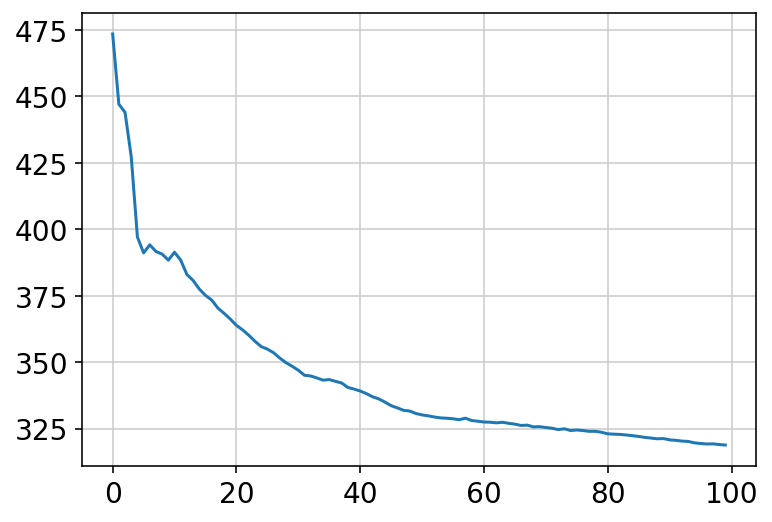

In [42]:
# Plot epoch vs train-error curve
plt.plot(range(100), all_loss_train)


In [46]:
# Plot epoch vs train-error curve


In [47]:
data_batch = list(zip(*dataset_test[0:100]))
preds, actual = model.forward_regressor(data_batch, features_test[:100], adj.todense(), train = False)

In [48]:
actual[:5]

array([  8.319962  ,  21.294733  , -42.1914    ,  -0.99427366,
        16.753506  ], dtype=float32)

In [49]:
preds[:5]

array([ -1.129737 ,  16.94623  , -12.76953  ,   4.5051703,  -7.5584607],
      dtype=float32)

In [52]:
# check correlation coeff
from sklearn.metrics import r2_score
r2_score(actual, preds)

0.2946425195295489

In [50]:
### This is good model
# torch.save(model, 'Trained Model GNN-GCN_100epochs_non-scaled_tanh-actfn/model')

In [ ]:
### REST-NON-TRAIN VALUES AS VALIDATION VALUES, BASED ALGORITHM:
### Use relu as activation functions to predict negative values and non-scaled outputs and 200 epochs


################################################################## RUN MODELLL

radius = 3
dim = 50

print('Creating a model.')
torch.manual_seed(1234)


model_relu = MolecularGraphNeuralNetwork(
        N_fingerprints, dim, layer_hidden, layer_output, nfeat=features_train.shape[1],nhid=256,nclass=1,dropout=0.2 ).to(device)
trainer_relu = Trainer(model_relu)
tester_relu = Tester(model_relu)
print('# of model parameters:',
      sum([np.prod(p.size()) for p in model_relu.parameters()]))
print('-'*100)

file_result = train_data_path + '/setting2_run.txt'

if task == 'regression':
    result = 'Epoch\tTime(sec)\tLoss_train\tMAE_dev\tMAE_test'

with open(file_result, 'w') as f:
    f.write(result + '\n')

print('Start training.')
print('The result is saved in the output directory every epoch!')

all_loss_train = []
all_valid_train = []

# np.random.seed(1234)

start = timeit.default_timer()

# BATCH THIS HERE AND ADJ MATRIX CALC EVERY TIME

# epoch_batch_size = int( len(dataset_train)/iteration )
# epoch_batch_size = 1000
epochs = 400

epoch_batch_size = 500
iterations_per_epoch = int(len(dataset_train)/epoch_batch_size)
print(epochs, iterations_per_epoch)

for epoch in range(epochs):
    
    batch_start_nd = 0
    batch_end_nd = epoch_batch_size
    print('Epoch: ', epoch, ' Batch size: ', epoch_batch_size)
    
    for iteration in range(iterations_per_epoch):
        # Dont decay lr
        # if epoch % decay_interval == 0:
        #     trainer.optimizer.param_groups[0]['lr'] *= lr_decay

        ds_train = dataset_train[batch_start_nd:batch_end_nd]
        fs_train = features_train[batch_start_nd:batch_end_nd]
        
        loss_train = trainer_relu.train(ds_train, fs_train, adj.todense(), train=True)
        
        batch_start_nd = batch_end_nd
        batch_end_nd = batch_start_nd + epoch_batch_size
        if(iteration == iterations_per_epoch - 1):
          batch_start_nd = batch_end_nd
          batch_end_nd = len(dataset_train)
        
        
    if task == 'regression':
      # do b-proc here
      valid_mse = '--------'
#       for i_valid in range(batch_end_nd, len(dataset_train), 1000):
#         # print('valid', i_valid)
#         data_dev_batch = dataset_train[i_valid:i_valid+1000]
#         prediction_dev = tester.test_regressor(data_dev_batch, features_train[i_valid:i_valid+1000], adj.todense())
#         valid_mse += prediction_dev

      print('train done')

      test_mse = 0
#       for i_test in range(0, len(dataset_test), 500):
#         # print('test', i_test)
#         data_test_batch = dataset_test[i_test:i_test+500]
#         prediction_test = tester_relu.test_regressor(data_test_batch, features_test[i_test:i_test+500], adj.todense())
#         test_mse += prediction_test

    time = timeit.default_timer() - start

    if epoch == 0:
        minutes = time * iteration / 60
        hours = int(minutes / 60)
        minutes = int(minutes - 60 * hours)
        print('The training will finish in about',
              hours, 'hours', minutes, 'minutes.')
        print('-'*100)
        print(result)

    result = '\t'.join(map(str, [epoch, time, loss_train,
                                 valid_mse, test_mse]))
    # tester.save_result(result, file_result)

    print(result)
    all_loss_train.append(loss_train)
    all_valid_train.append(test_mse)
    

Creating a model.
# of model parameters: 2312301
----------------------------------------------------------------------------------------------------
Start training.
The result is saved in the output directory every epoch!
400 30
Epoch:  0  Batch size:  500
train done
The training will finish in about 2 hours 48 minutes.
----------------------------------------------------------------------------------------------------
Epoch	Time(sec)	Loss_train	MAE_dev	MAE_test
0	347.9992331760004	488.6141357421875	--------	0
Epoch:  1  Batch size:  500
train done
1	696.4051312641241	425.5480041503906	--------	0
Epoch:  2  Batch size:  500
train done
2	1034.09450315102	426.2303161621094	--------	0
Epoch:  3  Batch size:  500
train done
3	1379.1659894511104	423.0334167480469	--------	0
Epoch:  4  Batch size:  500
train done
4	1725.5618353649043	389.6933288574219	--------	0
Epoch:  5  Batch size:  500
train done
5	2075.929360694019	342.5058898925781	--------	0
Epoch:  6  Batch size:  500
train done
6	2

In [ ]:
# ALSO TRIED LR = 0.01...NOISY CONVERGENCE

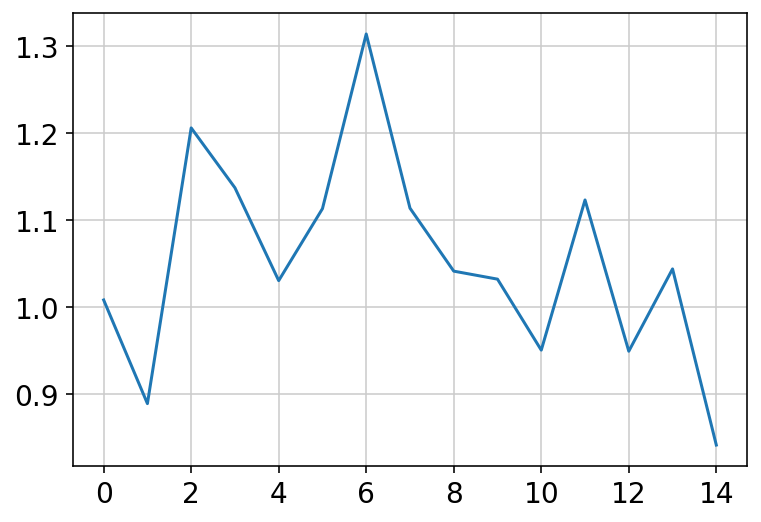

In [112]:
# Plot epoch vs train-error curve
plt.plot(range(15), all_loss_train)


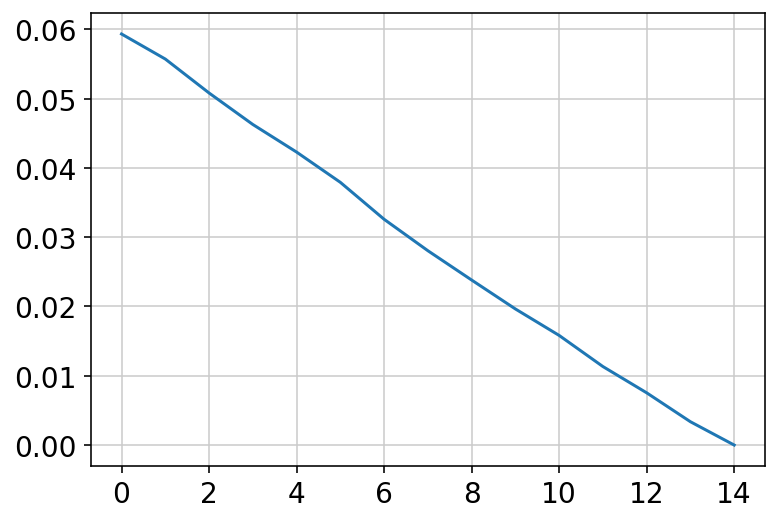

In [113]:
# Plot epoch vs train-error curve
plt.plot(range(15), all_valid_train)


In [111]:
gc.collect()

5637

In [44]:
data_batch = list(zip(*dataset_test[0:10]))

preds, actual = model.forward_regressor(data_batch, features_train[:10], adj.todense(), train = False)


#         predicted_values, correct_values = self.model.forward_regressor(
#                                             data_batch, x, adj, train=False)

In [45]:
# Inverse scale and compare metrics

preds_inv = scaler.inverse_transform(preds)
print(preds_inv.shape)
actual_inv = scaler.inverse_transform(actual)
print(actual_inv.shape)
# Check what acti function and scaling method to use to get negative predictions

(10,)
(10,)


In [46]:
from sklearn.metrics import mean_squared_error as mse_error
print('In scaled version, MSE is: ', mse_error(actual, preds))
print('In original version, MSE is: ', mse_error(actual_inv, preds_inv))


In scaled version, MSE is:  0.71597683
In original version, MSE is:  353.31335


In [49]:
preds_inv

array([6.5983844, 6.3946595, 6.0836906, 7.539284 , 5.916025 , 7.4351454,
       6.3773155, 6.9938483, 6.621343 , 7.9209294], dtype=float32)

In [156]:
actual_inv

array([  1.6303278,  20.362988 ,   2.1084578,  15.571226 , -15.15977  ,
         4.920735 ,   0.650415 , -18.720816 ,  49.16553  ,  24.608122 ],
      dtype=float32)

In [ ]:
# torch.save(model, 'Trained Model GNN-GCN/model')

In [157]:
preds

array([ 0.08618711,  0.04809671,  0.03189801,  0.0309574 ,  0.08550937,
       -0.03106661,  0.04023261,  0.01050187, -0.02593217,  0.02945607,
        0.07679251,  0.04852899,  0.08991359,  0.04468206,  0.079864  ,
        0.05929171,  0.03453385,  0.04569567,  0.06626941,  0.01343243,
        0.03089802, -0.0057711 ,  0.07312735,  0.04967072, -0.00220926,
        0.04631687,  0.01125146,  0.07468678,  0.02793835,  0.0475954 ,
        0.02787326,  0.0039828 , -0.00452556,  0.07961084,  0.09472699,
        0.05611373,  0.08974524,  0.01041357, -0.03830655,  0.03863859,
        0.09931492,  0.0422984 ,  0.08065198,  0.05897057,  0.01988907,
        0.03114261,  0.08027725,  0.04842329,  0.00887115, -0.02759029,
        0.05295374,  0.03695037,  0.03890365, -0.02818772,  0.03265865,
       -0.01213716,  0.00156318,  0.07989828, -0.03107905,  0.01537727,
        0.01923671,  0.04556826,  0.01862747,  0.04434333,  0.03850257,
        0.086329  ,  0.06393921, -0.00252621,  0.04496746,  0.04

In [36]:
### LEAVE ONE-OUT VALIDATION BASED ALGORITHM:


################################################################## RUN MODELLL

dim = 50
# iteration=10
print('Creating a model.')
torch.manual_seed(1234)


model = MolecularGraphNeuralNetwork(
        N_fingerprints, dim, layer_hidden, layer_output, nfeat=features_train.shape[1],nhid=256,nclass=1,dropout=0.2 ).to(device)
trainer = Trainer(model)
tester = Tester(model)
print('# of model parameters:',
      sum([np.prod(p.size()) for p in model.parameters()]))
print('-'*100)

file_result = train_data_path + '/setting1_run.txt'

if task == 'regression':
    result = 'Epoch\tTime(sec)\tLoss_train\tMAE_dev\tMAE_test'

with open(file_result, 'w') as f:
    f.write(result + '\n')

print('Start training.')
print('The result is saved in the output directory every epoch!')

all_loss_train = []
all_valid_train = []

# np.random.seed(1234)

start = timeit.default_timer()

# BATCH THIS HERE AND ADJ MATRIX CALC EVERY TIME

# epoch_batch_size = int( len(dataset_train)/iteration )
epoch_batch_size = 1000
batch_start_nd = 0
batch_end_nd = epoch_batch_size
# iteration = int(len(dataset_train)/epoch_batch_size)
iteration = 50
print(iteration)

for epoch in range(iteration):

    # Dont decay lr
    # if epoch % decay_interval == 0:
    #     trainer.optimizer.param_groups[0]['lr'] *= lr_decay

    ds_train = dataset_train[batch_start_nd:batch_end_nd]
    fs_train = features_train[batch_start_nd:batch_end_nd]


    print('Epoch: ', epoch)
    loss_train = trainer.train(ds_train, fs_train, adj.todense(), train=True)
    # print('done')
    if task == 'regression':
      # do b-proc here
      valid_mse = 0
      for i_valid in range(0, len(dataset_dev), 500):
        # print('valid', i_valid)
        data_dev_batch = dataset_dev[i_valid:i_valid+500]
        prediction_dev = tester.test_regressor(data_dev_batch, features_dev[i_valid:i_valid+500], adj.todense())
        valid_mse += prediction_dev

      print('valid done')

      test_mse = 0
      for i_test in range(0, len(dataset_test), 500):
        # print('test', i_test)
        data_test_batch = dataset_test[i_test:i_test+500]
        prediction_test = tester.test_regressor(data_test_batch, features_test[i_test:i_test+500], adj.todense())
        test_mse += prediction_test
    # test_mse = 0
    # prediction_test,prediction_dev = 0, 0

    time = timeit.default_timer() - start

    if epoch == 1:
        minutes = time * iteration / 60
        hours = int(minutes / 60)
        minutes = int(minutes - 60 * hours)
        print('The training will finish in about',
              hours, 'hours', minutes, 'minutes.')
        print('-'*100)
        print(result)

    result = '\t'.join(map(str, [epoch, time, loss_train,
                                 valid_mse, test_mse]))
    # tester.save_result(result, file_result)

    print(result)
    all_loss_train.append(loss_train)
    all_valid_train.append(valid_mse)
    epoch += 1

    batch_start_nd = batch_end_nd
    batch_end_nd = batch_start_nd + epoch_batch_size
    if(epoch == iteration):
      batch_start_nd = 0
      batch_end_nd = epoch_batch_size

Creating a model.
# of model parameters: 4191291
----------------------------------------------------------------------------------------------------
Start training.
The result is saved in the output directory every epoch!
50
Epoch:  0
valid done
0	128.22875083703548	1.006762981414795	0.005135622143745422	0.013355601730267645
Epoch:  1
valid done
The training will finish in about 3 hours 33 minutes.
----------------------------------------------------------------------------------------------------
0	128.22875083703548	1.006762981414795	0.005135622143745422	0.013355601730267645
1	255.76632208703086	0.8879749774932861	0.005129100680351257	0.013342782620566986
Epoch:  2
valid done
2	380.7526260970626	1.2042992115020752	0.005123589158058167	0.013330634168498423
Epoch:  3
valid done
3	508.72058509709314	1.1365541219711304	0.005120469212532043	0.01332176542743135
Epoch:  4
valid done
4	631.5647250551265	1.0405992269515991	0.005121366500854492	0.013317801544679462
Epoch:  5
valid done
5	759.

KeyboardInterrupt: 

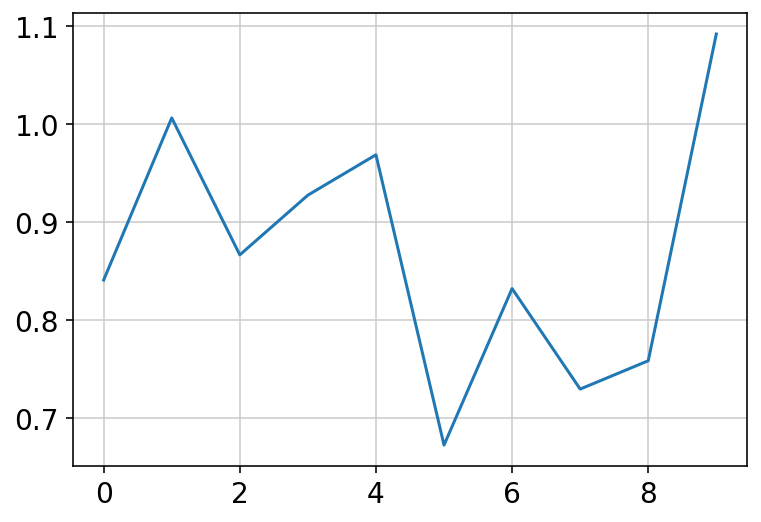

In [46]:
# Plot epoch vs train-error curve
plt.plot(range(10), all_loss_train)


In [1]:

# ################################################################## RUN MODELLL

# dim = 50
# iteration=50
# print('Creating a model.')
# torch.manual_seed(1234)


# model = MolecularGraphNeuralNetwork(
#         N_fingerprints, dim, layer_hidden, layer_output, nfeat=features_train.shape[1],nhid=16,nclass=1,dropout=0.2 ).to(device)
# trainer = Trainer(model)
# # tester = Tester(model)
# print('# of model parameters:',
#       sum([np.prod(p.size()) for p in model.parameters()]))
# print('-'*100)

# file_result = train_data_path + '/setting1_run.txt'

# if task == 'regression':
#     result = 'Epoch\tTime(sec)\tLoss_train\tMAE_dev\tMAE_test'

# with open(file_result, 'w') as f:
#     f.write(result + '\n')

# print('Start training.')
# print('The result is saved in the output directory every epoch!')

# all_loss_train = []


# # np.random.seed(1234)

# start = timeit.default_timer()

# # BATCH THIS HERE AND ADJ MATRIX CALC EVERY TIME

# # epoch_batch_size = int( len(dataset_train)/iteration )
# epoch_batch_size = 100
# batch_start_nd = 0
# batch_end_nd = epoch_batch_size
# iteration = int(len(dataset_train)/epoch_batch_size)
# print(iteration)

# for epoch in range(iteration*2):

#     # Dont decay lr
#     # if epoch % decay_interval == 0:
#     #     trainer.optimizer.param_groups[0]['lr'] *= lr_decay

#     ds_train = dataset_train[batch_start_nd:batch_end_nd]
#     fs_train = features_train[batch_start_nd:batch_end_nd]


#     print(epoch)
#     loss_train = trainer.train(ds_train, fs_train, adj, train=True)
#     print('done')
#     # if task == 'regression':
#     #     prediction_dev = tester.test_regressor(dataset_dev)
#     #     prediction_test = tester.test_regressor(dataset_test)
#     prediction_test,prediction_dev = 0, 0

#     time = timeit.default_timer() - start

#     if epoch == 1:
#         minutes = time * iteration / 60
#         hours = int(minutes / 60)
#         minutes = int(minutes - 60 * hours)
#         print('The training will finish in about',
#               hours, 'hours', minutes, 'minutes.')
#         print('-'*100)
#         print(result)

#     result = '\t'.join(map(str, [epoch, time, loss_train,
#                                  prediction_dev, prediction_test]))
#     # tester.save_result(result, file_result)

#     print(result)
#     all_loss_train.append(loss_train)
#     epoch += 1

#     batch_start_nd = batch_end_nd
#     batch_end_nd = batch_start_nd + epoch_batch_size
#     if(epoch == iteration):
#       batch_start_nd = 0
#       batch_end_nd = epoch_batch_size

The code uses a CPU...
Preprocessing the GNN  dataset.
Just a moment......
(10000, 5)
Skipped 1131 smiles in training data
----------------------------------------------------------------------------------------------------
The preprocess has finished!
# of training data samples: 7982
# of development data samples: 887
# of test data samples: 887
----------------------------------------------------------------------------------------------------


In [ ]:
n = int(0.9 * 5000)
n

4500

In [ ]:

################################################################## RUN MODELLL

dim = 50
iteration=100
print('Creating a model.')
torch.manual_seed(1234)
model = MolecularGraphNeuralNetwork(
        N_fingerprints, dim, layer_hidden, layer_output, ).to(device)
trainer = Trainer(model)
tester = Tester(model)
print('# of model parameters:',
      sum([np.prod(p.size()) for p in model.parameters()]))
print('-'*100)

file_result = train_data_path + '/setting1_run.txt'

if task == 'regression':
    result = 'Epoch\tTime(sec)\tLoss_train\tMAE_dev\tMAE_test'

with open(file_result, 'w') as f:
    f.write(result + '\n')

print('Start training.')
print('The result is saved in the output directory every epoch!')

all_loss_train = []


# np.random.seed(1234)

start = timeit.default_timer()

for epoch in range(iteration):

    # Dont decay lr
    # if epoch % decay_interval == 0:
    #     trainer.optimizer.param_groups[0]['lr'] *= lr_decay

    loss_train = trainer.train(dataset_train)

    if task == 'regression':
        prediction_dev = tester.test_regressor(dataset_dev)
        prediction_test = tester.test_regressor(dataset_test)

    time = timeit.default_timer() - start

    if epoch == 1:
        minutes = time * iteration / 60
        hours = int(minutes / 60)
        minutes = int(minutes - 60 * hours)
        print('The training will finish in about',
              hours, 'hours', minutes, 'minutes.')
        print('-'*100)
        print(result)

    result = '\t'.join(map(str, [epoch, time, loss_train,
                                 prediction_dev, prediction_test]))
    tester.save_result(result, file_result)

    print(result)
    all_loss_train.append(loss_train)
    epoch += 1


In [ ]:
!nvidia-smi

In [ ]:
import torch
torch.cuda.is_available()

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()